In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_prefix = "abalone"  # Change this to any word you like
df =  pd.read_csv(f'{file_prefix}_result.csv')


# Assuming you have a DataFrame named 'df'
df.columns.values[0] = 'Method'

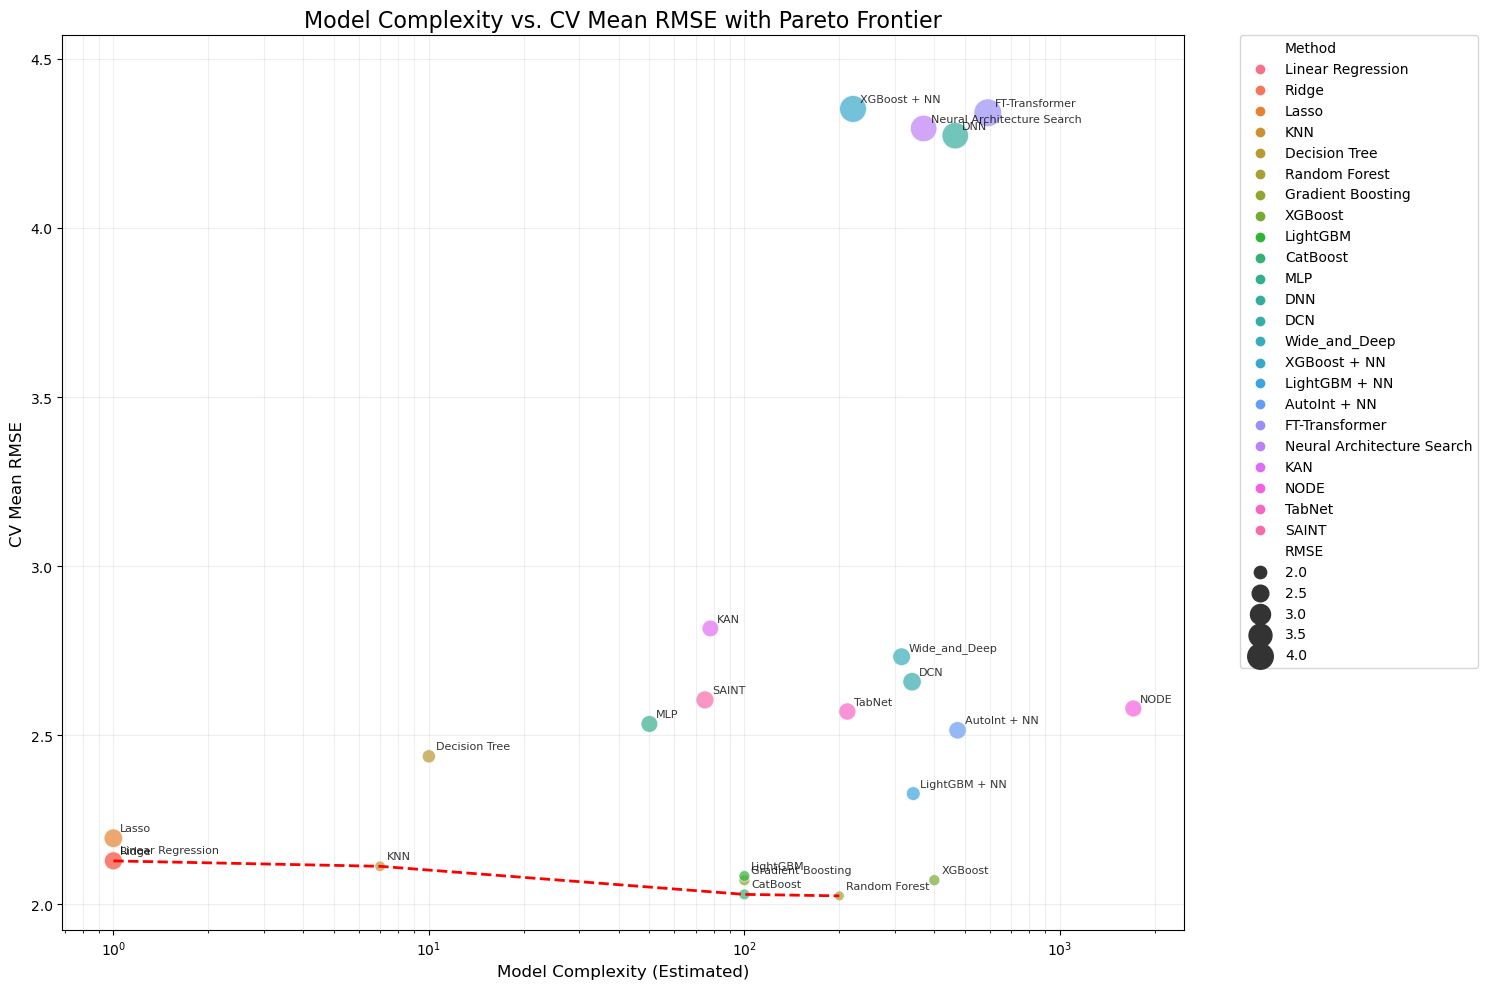

Linear Regression: Complexity = 1, CV Mean RMSE = 2.1301 - Not on Pareto frontier
Ridge: Complexity = 1, CV Mean RMSE = 2.1287 - On Pareto frontier
Lasso: Complexity = 1, CV Mean RMSE = 2.1957 - Not on Pareto frontier
KNN: Complexity = 7, CV Mean RMSE = 2.1127 - On Pareto frontier
Decision Tree: Complexity = 10, CV Mean RMSE = 2.4379 - Not on Pareto frontier
MLP: Complexity = 50, CV Mean RMSE = 2.5336 - Not on Pareto frontier
SAINT: Complexity = 75, CV Mean RMSE = 2.6048 - Not on Pareto frontier
KAN: Complexity = 78, CV Mean RMSE = 2.8159 - Not on Pareto frontier
LightGBM: Complexity = 100, CV Mean RMSE = 2.0841 - Not on Pareto frontier
CatBoost: Complexity = 100, CV Mean RMSE = 2.0297 - On Pareto frontier
Gradient Boosting: Complexity = 100, CV Mean RMSE = 2.0714 - Not on Pareto frontier
Random Forest: Complexity = 200, CV Mean RMSE = 2.0253 - On Pareto frontier
TabNet: Complexity = 212, CV Mean RMSE = 2.5705 - Not on Pareto frontier
XGBoost + NN: Complexity = 221, CV Mean RMSE = 4.35

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np

# Assuming df is your existing DataFrame
# If it's not already loaded, you would load it here, e.g.:
# df = pd.read_csv('your_data.csv')

def extract_complexity(row):
    params = ast.literal_eval(row['Best Parameters'])
    method = row['Method']
    
    if method in ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM', 'CatBoost']:
        return params.get('n_estimators', 100)  # Default to 100 if not specified
    elif method in ['DNN', 'DCN', 'Wide_and_Deep', 'AutoInt + NN', 'FT-Transformer']:
        total_neurons = sum(params.get(f'hidden_layer_{i}', 0) for i in range(3))
        return total_neurons
    elif method == 'MLP':
        layers = params['hidden_layer_sizes']
        return sum(layers) if isinstance(layers, tuple) else layers
    elif method == 'TabNet':
        return params['n_d'] * params['n_steps']
    elif method == 'SAINT':
        return params['heads'] * params['dim'] * params['depth']
    elif method == 'Neural Architecture Search':
        return params['num_layers'] * max(params.get(f'hidden_layer_{i}', 0) for i in range(2))
    elif method == 'KAN':
        return params['hidden_dim']
    elif method == 'NODE':
        return params['num_layers'] * params['num_trees'] * params['tree_dim']
    elif method == 'XGBoost + NN' or method == 'LightGBM + NN':
        return params['n_estimators'] + sum(params.get(f'hidden_layer_{i}', 0) for i in range(3))
    elif method == 'KNN':
        return params['n_neighbors']
    elif method == 'Decision Tree':
        return params['max_depth']
    elif method in ['Linear Regression', 'Ridge', 'Lasso']:
        return 1  # These are linear models, so we assign them the lowest complexity
    else:
        # For models where we can't easily determine complexity, return a small default value
        return 1

# Apply the complexity measure
df['Complexity'] = df.apply(extract_complexity, axis=1)

# Function to identify Pareto-optimal points
def is_pareto_efficient(costs):
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

# Identify Pareto-optimal points
costs = df[['Complexity', 'CV Mean RMSE']].values
pareto_optimal = is_pareto_efficient(costs)

# Create the plot
plt.figure(figsize=(15, 10))

# Create the scatter plot
scatter = sns.scatterplot(data=df, x='Complexity', y='CV Mean RMSE', 
                          hue='Method', size='RMSE', sizes=(50, 400), alpha=0.7)

# Plot Pareto frontier
pareto_points = df[pareto_optimal].sort_values('Complexity')
plt.plot(pareto_points['Complexity'], pareto_points['CV Mean RMSE'], 'r--', linewidth=2)

# Customize the plot
plt.title('Model Complexity vs. CV Mean RMSE with Pareto Frontier', fontsize=16)
plt.xlabel('Model Complexity (Estimated)', fontsize=12)
plt.ylabel('CV Mean RMSE', fontsize=12)

# Add model names as annotations
for i, row in df.iterrows():
    plt.annotate(row['Method'], (row['Complexity'], row['CV Mean RMSE']),
                 xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

# Adjust axes
plt.xscale('log')  # Use log scale for complexity
plt.ylim(df['CV Mean RMSE'].min() * 0.95, df['CV Mean RMSE'].max() * 1.05)  # Adjust y-axis to focus on the range of RMSE values

# Add gridlines for better readability
plt.grid(True, which="both", ls="-", alpha=0.2)

# Adjust legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

# Print out the complexity values for each method and indicate if it's on the Pareto frontier
for _, row in df.sort_values('Complexity').iterrows():
    pareto_status = "On Pareto frontier" if row.name in pareto_points.index else "Not on Pareto frontier"
    print(f"{row['Method']}: Complexity = {row['Complexity']}, CV Mean RMSE = {row['CV Mean RMSE']:.4f} - {pareto_status}")

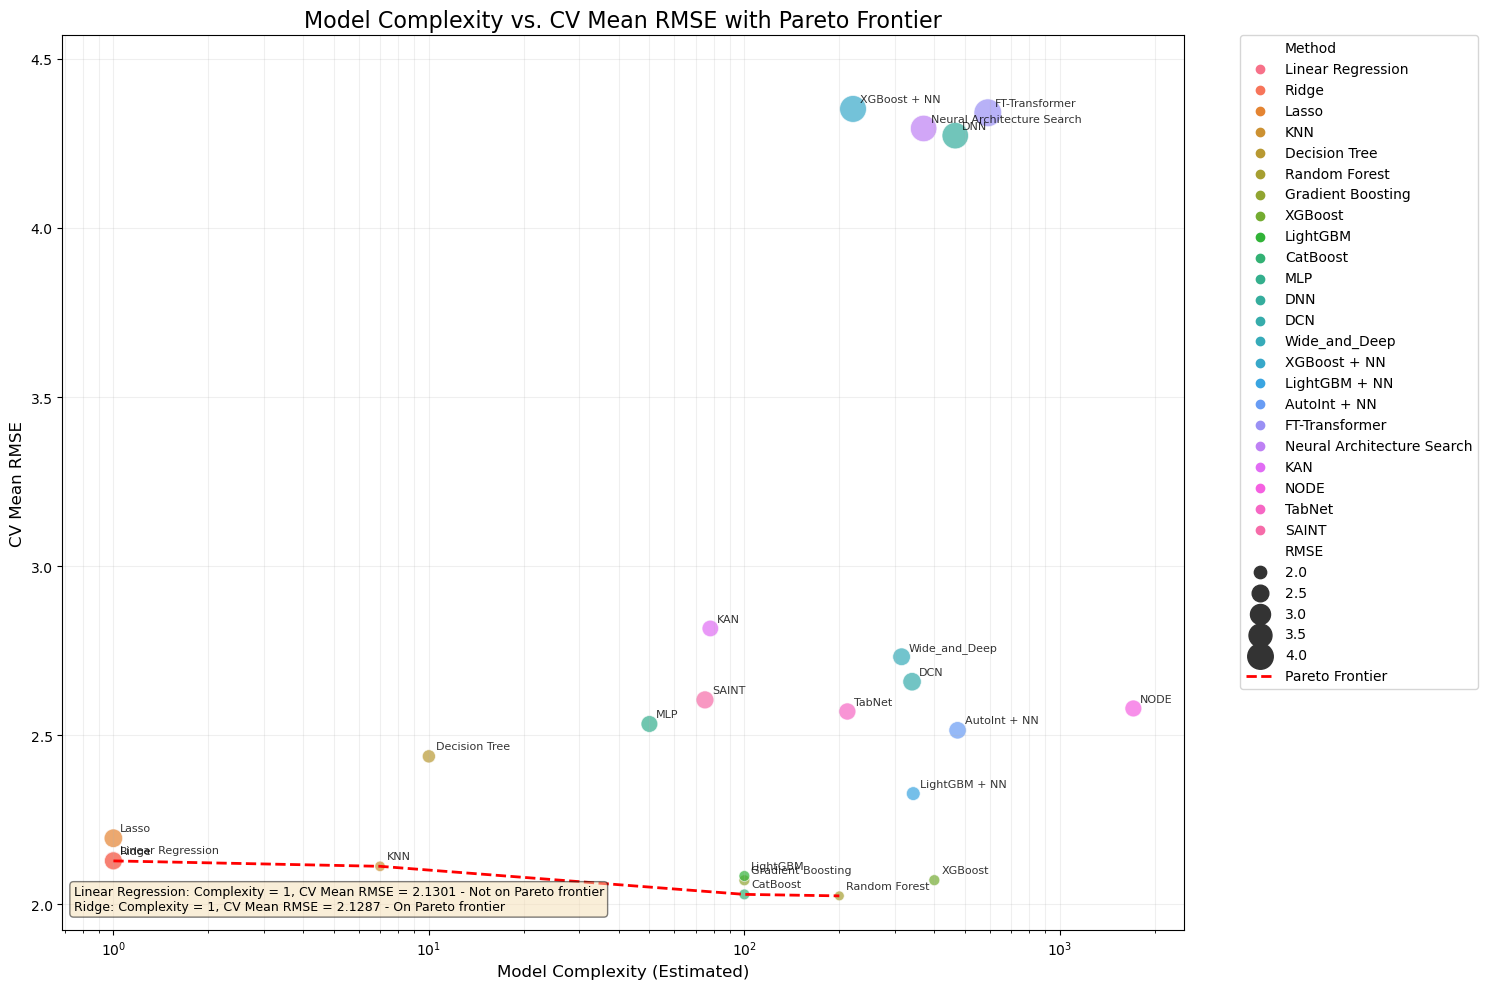

Linear Regression: Complexity = 1, CV Mean RMSE = 2.1301 - Not on Pareto frontier
Ridge: Complexity = 1, CV Mean RMSE = 2.1287 - On Pareto frontier
Lasso: Complexity = 1, CV Mean RMSE = 2.1957 - Not on Pareto frontier
KNN: Complexity = 7, CV Mean RMSE = 2.1127 - On Pareto frontier
Decision Tree: Complexity = 10, CV Mean RMSE = 2.4379 - Not on Pareto frontier
MLP: Complexity = 50, CV Mean RMSE = 2.5336 - Not on Pareto frontier
SAINT: Complexity = 75, CV Mean RMSE = 2.6048 - Not on Pareto frontier
KAN: Complexity = 78, CV Mean RMSE = 2.8159 - Not on Pareto frontier
LightGBM: Complexity = 100, CV Mean RMSE = 2.0841 - Not on Pareto frontier
CatBoost: Complexity = 100, CV Mean RMSE = 2.0297 - On Pareto frontier
Gradient Boosting: Complexity = 100, CV Mean RMSE = 2.0714 - Not on Pareto frontier
Random Forest: Complexity = 200, CV Mean RMSE = 2.0253 - On Pareto frontier
TabNet: Complexity = 212, CV Mean RMSE = 2.5705 - Not on Pareto frontier
XGBoost + NN: Complexity = 221, CV Mean RMSE = 4.35

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np

# Assuming df is your existing DataFrame
# If it's not already loaded, you would load it here, e.g.:
# df = pd.read_csv('your_data.csv')

def extract_complexity(row):
    params = ast.literal_eval(row['Best Parameters'])
    method = row['Method']
    
    if method in ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM', 'CatBoost']:
        return params.get('n_estimators', 100)  # Default to 100 if not specified
    elif method in ['DNN', 'DCN', 'Wide_and_Deep', 'AutoInt + NN', 'FT-Transformer']:
        total_neurons = sum(params.get(f'hidden_layer_{i}', 0) for i in range(3))
        return total_neurons
    elif method == 'MLP':
        layers = params['hidden_layer_sizes']
        return sum(layers) if isinstance(layers, tuple) else layers
    elif method == 'TabNet':
        return params['n_d'] * params['n_steps']
    elif method == 'SAINT':
        return params['heads'] * params['dim'] * params['depth']
    elif method == 'Neural Architecture Search':
        return params['num_layers'] * max(params.get(f'hidden_layer_{i}', 0) for i in range(2))
    elif method == 'KAN':
        return params['hidden_dim']
    elif method == 'NODE':
        return params['num_layers'] * params['num_trees'] * params['tree_dim']
    elif method == 'XGBoost + NN' or method == 'LightGBM + NN':
        return params['n_estimators'] + sum(params.get(f'hidden_layer_{i}', 0) for i in range(3))
    elif method == 'KNN':
        return params['n_neighbors']
    elif method == 'Decision Tree':
        return params['max_depth']
    elif method in ['Linear Regression', 'Ridge', 'Lasso']:
        return 1  # These are linear models, so we assign them the lowest complexity
    else:
        return 1

# Apply the complexity measure
df['Complexity'] = df.apply(extract_complexity, axis=1)

# Function to identify Pareto-optimal points
def is_pareto_efficient(costs):
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)
            is_efficient[i] = True
    return is_efficient

# Identify Pareto-optimal points
costs = df[['Complexity', 'CV Mean RMSE']].values
pareto_optimal = is_pareto_efficient(costs)

# Create the plot
plt.figure(figsize=(15, 10))

# Create the scatter plot
scatter = sns.scatterplot(data=df, x='Complexity', y='CV Mean RMSE', 
                          hue='Method', size='RMSE', sizes=(50, 400), alpha=0.7)

# Plot Pareto frontier
pareto_points = df[pareto_optimal].sort_values('Complexity')
plt.plot(pareto_points['Complexity'], pareto_points['CV Mean RMSE'], 'r--', linewidth=2, label='Pareto Frontier')

# Customize the plot
plt.title('Model Complexity vs. CV Mean RMSE with Pareto Frontier', fontsize=16)
plt.xlabel('Model Complexity (Estimated)', fontsize=12)
plt.ylabel('CV Mean RMSE', fontsize=12)

# Add model names as annotations
for i, row in df.iterrows():
    plt.annotate(row['Method'], (row['Complexity'], row['CV Mean RMSE']),
                 xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

# Add text box for Linear Regression, Ridge, and Lasso
textstr = '\n'.join((
    'Linear Regression: Complexity = 1, CV Mean RMSE = 2.1301 - Not on Pareto frontier',
    'Ridge: Complexity = 1, CV Mean RMSE = 2.1287 - On Pareto frontier'
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.01, 0.05, textstr, transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='top', bbox=props)

# Adjust axes
plt.xscale('log')
plt.ylim(df['CV Mean RMSE'].min() * 0.95, df['CV Mean RMSE'].max() * 1.05)

# Add gridlines for better readability
plt.grid(True, which="both", ls="-", alpha=0.2)

# Adjust legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

# Print out the complexity values for each method and indicate if it's on the Pareto frontier
for _, row in df.sort_values('Complexity').iterrows():
    pareto_status = "On Pareto frontier" if row.name in pareto_points.index else "Not on Pareto frontier"
    print(f"{row['Method']}: Complexity = {row['Complexity']}, CV Mean RMSE = {row['CV Mean RMSE']:.4f} - {pareto_status}")